# Productivity in Article and Article Talk

We focus on the Article and Article Talk namespaces in the activation and retention analysis, as that's where the results are. Due to that, we'd like to fit additional models for productivity using just those namespaces. This is similar to the other productivity models, and will be run in parallel in three notebooks to make things go faster.

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
library(data.table)
library(ggplot2)

library(brms) # install.packages("brms")
library(loo) # install.packages("loo")
options(mc.cores = 4)
library(rstanarm) # install.packages("rstanarm")

Loading required package: Rcpp

Loading 'brms' package (version 2.14.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


This is loo version 2.3.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())


Attaching package: ‘rstanarm’


The following objects are masked from ‘package:brms’:

 

## Configuration variables

In [4]:
## Set BLAS threads to 4 so glmer and loo don't use all cores
library(RhpcBLASctl)
blas_set_num_threads(1)

## parallelization
options(mc.cores = 4)

### Data import and setup

In [5]:
user_edit_data = fread('/home/nettrom/src/Growth-homepage-2019/datasets/newcomer_tasks_edit_data_may2020.tsv',
                       colClasses = c(wiki_db = 'factor'))

In [6]:
## Configuration variables for this experiment.
## Start timestamp is from https://phabricator.wikimedia.org/T227728#5680453
## End timestamp is from the data gathering notebook
start_ts = as.POSIXct('2019-11-21 00:24:32', tz = 'UTC')
end_ts = as.POSIXct('2020-04-9 00:00', tz = 'UTC')

## Start of the Variant A/B test
variant_test_ts = as.POSIXct('2019-12-13 00:32:04', tz = 'UTC')

## Convert user_registration into a timestamp
user_edit_data[, user_reg_ts := as.POSIXct(user_registration_timestamp,
                                           format = '%Y-%m-%d %H:%M:%S.0', tz = 'UTC')]

## Calculate time since start of experiment in weeks
user_edit_data[, exp_days := 0]
user_edit_data[, exp_days := difftime(user_reg_ts, start_ts, units = 'days')]
user_edit_data[exp_days < 0, exp_days := 0]
user_edit_data[, ln_exp_days := log(1 + as.numeric(exp_days))]
user_edit_data[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Calculate time since the start of the variant test, again in days and weeks.
## This enables us to do an interrupted time-series model for that.
user_edit_data[, variant_exp_days := 0]
user_edit_data[, variant_exp_days := difftime(user_reg_ts, variant_test_ts, units = 'days')]
user_edit_data[variant_exp_days < 0, variant_exp_days := 0]
user_edit_data[, ln_var_exp_days := log(1 + as.numeric(variant_exp_days))]
user_edit_data[, ln_var_exp_weeks := log(1 + as.numeric(variant_exp_days)/7)]
user_edit_data[, in_var_exp := 0]
user_edit_data[user_reg_ts > variant_test_ts, in_var_exp := 1]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(user_edit_data)

## Turn "reg_on_mobile" into a factor for more meaningful plots
user_edit_data[, platform := 'desktop']
user_edit_data[reg_on_mobile == 1, platform := 'mobile']
user_edit_data[, platform := factor(platform)]

## Control variables for various forms of activation
user_edit_data[, is_activated_article := num_article_edits_24hrs > 0]
user_edit_data[, is_activated_other := num_other_edits_24hrs > 0]
user_edit_data[, is_activated := is_activated_article | is_activated_other]

## Control variables for constructive forms of activation
user_edit_data[, is_const_activated_article := (num_article_edits_24hrs - num_article_reverts_24hrs) > 0]
user_edit_data[, is_const_activated_other := (num_other_edits_24hrs - num_other_reverts_24hrs) > 0]
user_edit_data[, is_const_activated := is_const_activated_article | is_const_activated_other]

## Control variables for the number of edits made
user_edit_data[, log_num_article_edits_24hrs := log(1 + num_article_edits_24hrs)]
user_edit_data[, log_num_other_edits_24hrs := log(1 + num_other_edits_24hrs)]
user_edit_data[, log_num_edits_24hrs := log(1 + num_article_edits_24hrs + num_other_edits_24hrs)]

## Control variables for the constructive number of edits made
user_edit_data[, log_num_const_article_edits_24hrs := log(
    1 + num_article_edits_24hrs - num_article_reverts_24hrs)]
user_edit_data[, log_num_const_other_edits_24hrs := log(
    1 + num_other_edits_24hrs - num_other_reverts_24hrs)]
user_edit_data[, log_num_const_edits_24hrs := log(
    1 + num_article_edits_24hrs + num_other_edits_24hrs -
    num_article_reverts_24hrs - num_other_reverts_24hrs)]

## Retention variables
user_edit_data[, is_const_retained_article := is_activated_article &
               ((num_article_edits_2w - num_article_reverts_2w) > 0)]
user_edit_data[, is_const_retained_other := is_const_activated_other &
               ((num_other_edits_2w - num_other_reverts_2w) > 0)]
user_edit_data[, is_const_retained := is_const_activated &
               ((num_article_edits_2w + num_other_edits_2w -
                 num_article_reverts_2w - num_other_reverts_2w) > 0)]

## Variables for number of edits (overall and only constructive)
## across the entire period.
user_edit_data[, num_total_edits_24hrs := num_article_edits_24hrs + num_other_edits_24hrs]
user_edit_data[, num_total_edits_2w := num_article_edits_2w + num_other_edits_2w]
user_edit_data[, num_total_edits := num_total_edits_24hrs + num_total_edits_2w]

user_edit_data[, num_total_const_edits_24hrs := (num_article_edits_24hrs + num_other_edits_24hrs -
                                                 num_article_reverts_24hrs - num_other_reverts_24hrs)]
user_edit_data[, num_total_const_edits_2w := (num_article_edits_2w + num_other_edits_2w -
                                              num_article_reverts_2w - num_other_reverts_2w)]
user_edit_data[, num_total_const_edits := num_total_const_edits_24hrs + num_total_const_edits_2w]

## Variables for number of article edits across the entire period.
user_edit_data[, num_total_article_edits := num_article_edits_24hrs + num_article_edits_2w]

## Priors

In [6]:
## Note that using a student_t distribution for the prior is beneficial because that
## distribution handles outliers better than a Normal.
## See https://jrnold.github.io/bayesian_notes/robust-regression.html
## Thanks to Mikhail for sending that to me!
priors <- prior(cauchy(0, 2), class = sd) +
  prior(student_t(5, 0, 10), class = b)

## Edits across the entire 15-day period

We base this model on the same one used across all namespaces, meaning that we don't expect group-level variation in the effect of mobile. This is mainly because we have few wikis in our dataset, thus we don't expect that to contain meaningful information.

In [ ]:
article_edits_2w.zinb.mod.1 <- brm(
  bf(num_total_article_edits ~ is_treatment * in_var_exp + reg_on_mobile + (1 | wiki_db),
     zi ~ wiki_db + reg_on_mobile),
    data = user_edit_data,
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 800,
    control = list(adapt_delta = 0.999,
                 max_treedepth = 15)
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(article_edits_2w.zinb.mod.1, file='models/article_edits_2w.zinb.mod.1.Robj')

In [10]:
summary(article_edits_2w.zinb.mod.1)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_article_edits ~ is_treatment * in_var_exp + reg_on_mobile + (1 | wiki_db) 
         zi ~ wiki_db + reg_on_mobile
   Data: user_edit_data (Number of observations: 97755) 
Samples: 4 chains, each with iter = 800; warmup = 400; thin = 1;
         total post-warmup samples = 1600

Group-Level Effects: 
~wiki_db (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.99      0.62     0.39     2.67 1.01      501      697

Population-Level Effects: 
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                   0.31      0.59    -1.03     1.30 1.01      370
zi_Intercept               -2.43      0.14    -2.73    -2.16 1.00     1219
is_treatment                0.20      0.06     0.09     0.30 1.01      937
in_var_exp                  0.32      0.05     0.23     0.41 1.00      997
reg_on_mobile

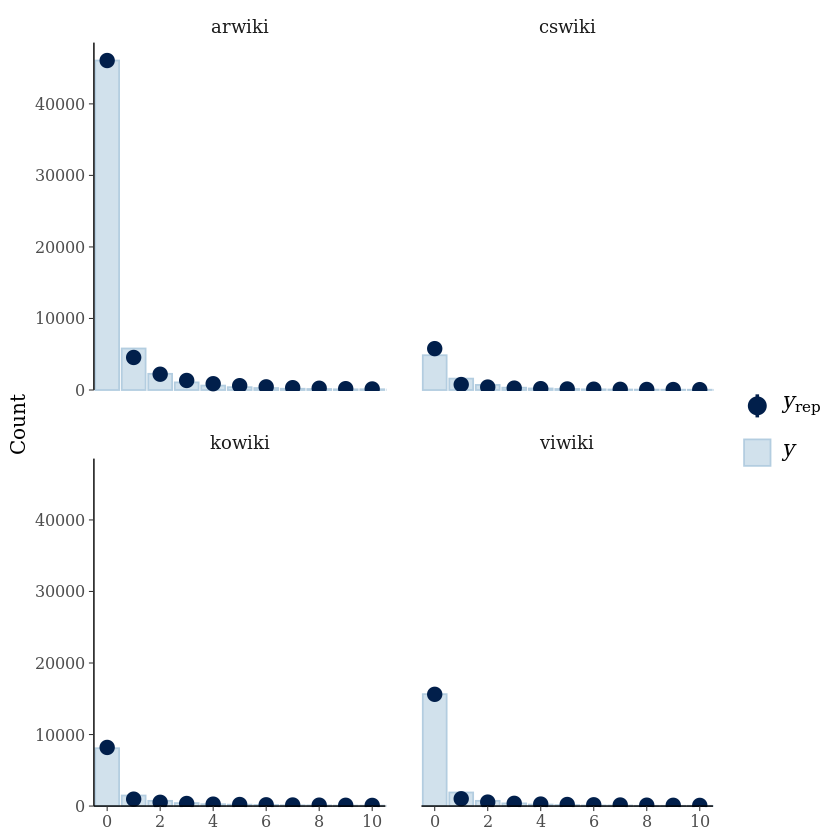

In [11]:
pp_check(article_edits_2w.zinb.mod.1, 
         nsamples = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(0, 10));

Zooming in on the non-zero part of the distributions, because the high zero-rate results in such a compressed graph.

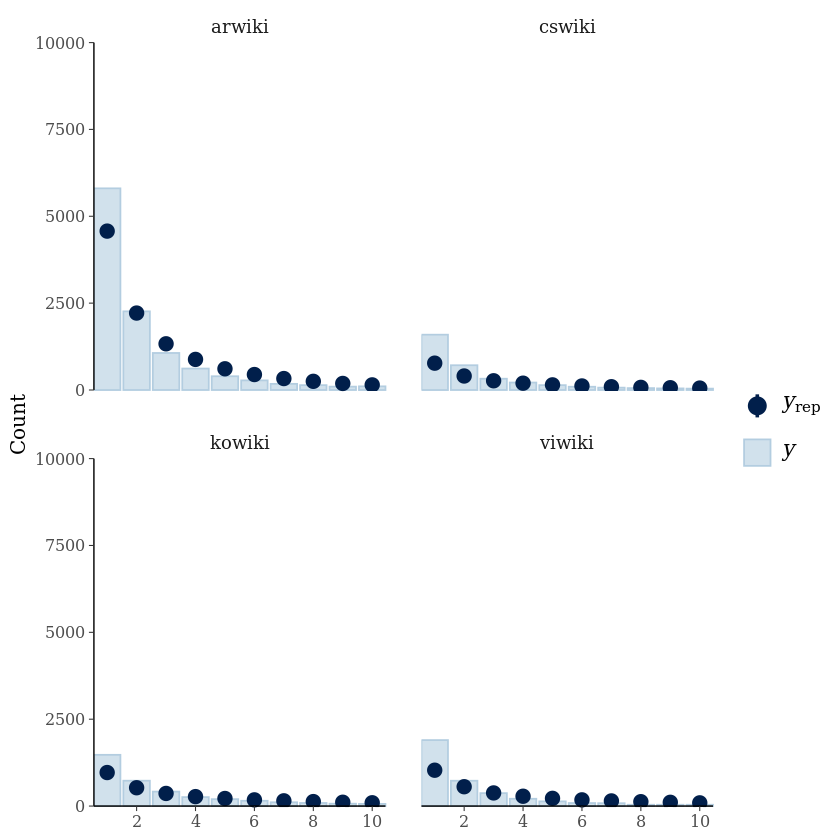

In [12]:
pp_check(article_edits_2w.zinb.mod.1, 
         nsamples = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(1, 10), ylim = c(0, 10000));

This pattern is similar to that of the overall model in that it underestimates the number of ones, and sometimes twos. Something to keep in mind moving forward, if there are ways for us to improve on that.

In [13]:
## Get predictions from the model about what the expected number of edits
## are for a user in the Control and Homepage groups for all wikis.
predict_data = data.frame(
    wiki_db = c(rep('arwiki', 4), rep('cswiki', 4),
                rep('kowiki', 4), rep('viwiki', 4)),
    reg_on_mobile = rep(c(0, 0, 1, 1), 4),
    is_treatment = rep(c(0, 1), 8),
    in_var_exp = rep(0, 16))

cbind(predict_data,
      round(predict(article_edits_2w.zinb.mod.1, predict_data, type = "response"), 1))

wiki_db,reg_on_mobile,is_treatment,in_var_exp,Estimate,Est.Error,Q2.5,Q97.5
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arwiki,0,0,0,0.6,1.9,0,6
arwiki,0,1,0,0.8,2.3,0,7
arwiki,1,0,0,0.5,1.6,0,5
arwiki,1,1,0,0.7,2.0,0,6
cswiki,0,0,0,1.2,3.3,0,11
cswiki,0,1,0,1.6,4.7,0,14
cswiki,1,0,0,1.5,3.8,0,13
cswiki,1,1,0,1.7,4.6,0,13
kowiki,0,0,0,2.3,6.3,0,19
